In [5]:
# Importing necessary libraries
from pythtb import *
import matplotlib.pyplot as plt

# Initializing the Wannier90 model by reading the data files
pgda=w90(r"/home/alwin/Downloads/long_Aprilexp2025/PdGa_Hamiltonian/Phosphorene",r"wannier90")
my_model=pgda.model(min_hopping_norm=0.01) # only hoppings with norm greater than 0.01 are considered

In [6]:
# To write the band velocity operator at a k-point
def calculate_v(k_vec, dk=0.01):
    H = my_model._gen_ham([k_vec[0], k_vec[1], k_vec[2]])
    Hx = my_model._gen_ham([k_vec[0]+dk, k_vec[1], k_vec[2]])
    Hy = my_model._gen_ham([k_vec[0], k_vec[1]+dk, k_vec[2]])
    Hz = my_model._gen_ham([k_vec[0], k_vec[1], k_vec[2]+dk])

    vx = (Hx-H)/dk
    vy = (Hy-H)/dk
    vz = (Hz-H)/dk
    return np.array((vx, vy, vz))

In [9]:
# To get energy eigenvalues and corresponding OBC (Omega^z_xy) at a k-point
def solve_and_calculate_Omega_xyz(k_vec, eta=0.0001):
    v = calculate_v(k_vec)                  # velocity using forward finite difference
    #v = my_model.derivative_ham(k_vec)     # velocity using exact derivative formula
    (eig_values, eig_vectors) = my_model.solve_one(k_vec, eig_vectors=True)
    
    # Calculating L_z
    Lz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp += (eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
            temp -= (eig_vectors[n].conjugate().dot(v[1]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[0]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
        Lz[n] = np.imag(temp)
    
    # Calculating Omega^z_xy
    Omega_xyz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp -= (Lz[m]+Lz[n])*(eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))**2
        Omega_xyz[n] = np.imag(temp/2)
    return (eig_values, Omega_xyz)

In [15]:
# Choosing the path
path=[[0.0,0.5,0.0],[0.0,0.0,0.0],[0.5,0.0,0.0]]
k_label=(r'$Y$',r'$\Gamma$',r'$X$')
(k_vec,k_dist,k_node)=my_model.k_path(path,501,report=False)
# Calculating OBC
evals = np.zeros((24, k_vec.shape[0]))
Omega_xyz = np.zeros((24, k_vec.shape[0]))
for i in range(k_vec.shape[0]):
    (evals[:, i], Omega_xyz[:, i]) = solve_and_calculate_Omega_xyz(k_vec[i])
    if i%100 == 0:
        print(i+1, "points done.")

1 points done.
101 points done.
201 points done.
301 points done.
401 points done.
501 points done.


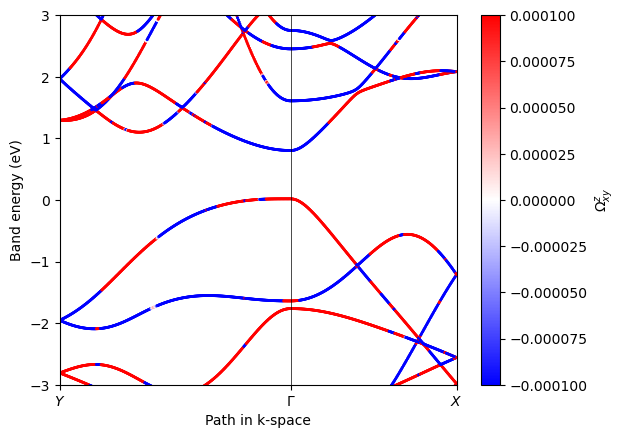

In [23]:
# Plotting

colors = Omega_xyz
energies = evals + 2.8123 # Subtracting the Fermi energy
cmax = 1e-4
plt.set_cmap('bwr')
for i in range(energies.shape[0]):
    plt.scatter(k_dist,energies[i], s=1, c=Omega_xyz[i])
    plt.clim(-cmax, cmax)
plt.colorbar(label="$\\Omega^z_{xy}$")
for n in range(len(k_node)):
    plt.axvline(x=k_node[n],linewidth=0.5, color='k')
plt.xlabel("Path in k-space")
plt.ylabel("Band energy (eV)")
plt.xlim(k_dist[0],k_dist[-1])
plt.ylim(-3.0, 3.0)
plt.xticks(k_node, labels=k_label)
plt.show()